In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='b2f906e8-963e-46de-b4ea-10dddd314d57', project_access_token='p-8b6a1b568ba6eebb5988bf98c9a72946fc2a2383')


# Deep Learning and Model Evaluations on Fashion-MNIST Dataset

In the second notebook `Part 2 - ML and Model Comparisons` we've trained three machine learning classifiers using the [Fashion-MNIST dataset from the Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/fashion-mnist/). In this notebook we will use the [Keras deep learning Python library](https://keras.io/) to build and train a model that can be used to identify and classify fashion and clothing items.


### Table of Contents:
* [0. Prerequisites](#cell0)
* [1. Read Data](#cell1)
* [2. Prepare the Data For Training](#cell2)
* [3. Build the Model](#cell3)
* [4. Train the Model](#cell4)
* [5. Test and Evaluate Model Performance](#cell5)
* [Authors](#authors)


<a id="cell0"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Install and import required packages

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required packages

Install and import the required packages, including `pandas`, `matplotlib`, `tensorflow`, `numpy`, `sklearn` and `seaborn`.

In [2]:
# Define required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import seaborn as sns

<a id="cell1"></a>

### 1. Read Data

We start by reading in training data from `fashion-mnist_train.csv` and test data from `fashion-mnist_test.csv` into arrays. Each row contains a class label and pixel data.

In [3]:
def get_file_handle(fname):
    """
    Return a buffered stream for the data asset named fname
    """
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# load training data into an array
DATA_PATH = 'fashion-mnist_train.csv'
data_path = get_file_handle(DATA_PATH)
data = pd.read_csv(data_path).values

print('Loaded {} data rows from {}.'.format(len(data), DATA_PATH))

# load test data into an array
DATA_PATH = 'fashion-mnist_test.csv'
# Using pandas to read the test data 
data_path = get_file_handle(DATA_PATH)
test_data = pd.read_csv(data_path).values

print('Loaded {} data rows from {}.'.format(len(test_data), DATA_PATH))

Loaded 60000 data rows from fashion-mnist_train.csv.
Loaded 10000 data rows from fashion-mnist_test.csv.


<a id="cell2"></a>

### 2. Prepare the Data For Training



#### Process item labels

Each row in the training and test dataset files contains a label that identifies the clothing item that is depicted by the pixel data. The label is expressed as a number between 0 and 9, and mapped as follows:

- 0 - T-shirt/top
- 1 - Trouser 
- 2 - Pullover
- 3 - Dress  
- 4 - Coat  
- 5 - Sandal  
- 6 - Shirt  
- 7 - Sneaker  
- 8 - Bag  
- 9 - Ankle boot 

We start by defining a simple mapping between the label number and a textual description, which we'll use to make the output more reader-friendly.

In [4]:
# define simple label lookup used to display user-friendly labels
label_map = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

Extract the labels for each image in the dataset, which is the first value in each row. 

In [5]:
# get the label of each picture
Y_train = data[:,0]

# display first label for illustrative purposes
print('Label: {} ("{}")'.format(Y_train[0], label_map[Y_train[0]]))

Label: 2 ("Pullover")


We use scikit-learn's [`sklearn.preprocessing.LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to binarize the labels in a [one-vs-all](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) fashion.

In [6]:
# Encode the labels into binary forms
lb = preprocessing.LabelBinarizer()
label_data = lb.fit_transform(Y_train)

Each label is now transformed into an array of 0s and 1s, as shown in the example below for the first row in the data set:

In [7]:
# display first encoded label for illustrative purposes
print('Label: {} ("{}") Binary label: {}'.format(Y_train[0], label_map[Y_train[0]], label_data[0]))

Label: 2 ("Pullover") Binary label: [0 0 1 0 0 0 0 0 0 0]


Let's make sure that there are no unexpected labels in the training dataset file. The output should only list the numbers 0 through 9.

In [8]:
print(lb.classes_)

[0 1 2 3 4 5 6 7 8 9]


#### Process pixel data


As we've discussed in the first notebook when we explored the dataset, the grayscale clothing images are 28px by 28px images in size (for a total of 784) and encoded as pixel values.
Extract the pixel values and store them in a Numpy array.

In [9]:
X_train = data[:, 1:].reshape(data.shape[0],28, 28, 1).astype( 'float32' )
print('Training data shape', X_train.shape)

Training data shape (60000, 28, 28, 1)


The pixel data in each row contain brightness information for each pixel in the 28x28 grayscale image. The pixel brightness is stored as an 8-bit integer, ranging from 0 (typically representing black) to 255 (white). Values in between represent different shades of gray. To normalize the values, we therefore need to divide each pixel data value by 255.

In [10]:
input_data = X_train/ 255.0

<a id="cell3"></a>
### 3. Build the Model

Keras is a high-level neural networks API that can run on top of [TensorFlow](https://www.tensorflow.org/), the [Microsoft Cognitive Toolkit (CNTK)](https://docs.microsoft.com/en-us/cognitive-toolkit/), or [Theano](http://www.deeplearning.net/software/theano/). In this notebook we will utilize the Tensorflow [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) module.

In Keras, you assemble layers to build models. A model is usually a graph of layers. The most common type of model is a stack of layers: the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model.

In [11]:
model = tf.keras.Sequential()

#### Set up the layers

The basic building block of a neural network constitutes multiple layers. Layers extract representations from the data fed into them. Generally, most deep learning models consist of multiple simple layers which are chained together. We use three basic layers as building blocks for our classifier - convolution layer, max pooling layer, and dense layer. These building blocks are common starting points for solving vision problems using deep learning as evidenced by their usage in almost all modern day peer to peer publications in this field.

It is beyond the scope of this notebook to explain the chosen [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and how to tune the hyper parameters to improve performance. Simplified speaking, the model extracts features from the image using convolutional and pooling layers and classifies the object using the dense softmax layer.

In [12]:
# Add a 2D convolution layer with 64 units to the model
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
# Add a max pooling operation for spatial data
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# Add a 2D convolution layer with 32 units to the model
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# Add a max pooling operation for spatial data
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# Add a flattened input layer
model.add(tf.keras.layers.Flatten())
# Add a densely-connected layer with 256 units to the model:
model.add(tf.keras.layers.Dense(256, activation='relu'))
# Add a layer that applies Dropout to the input
model.add(tf.keras.layers.Dropout(0.5))
# Add a softmax layer with 10 output units:
model.add(tf.keras.layers.Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Print the model summary.

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
__________

<a id="cell4"></a>
### 4. Train the Model

Now that we've created the model we need to configure it for training.

#### Configure model training


Let's first define the terms _loss function_ and _accuracy metric_.

A loss function is used to optimize a machine learning algorithm. The loss is calculated on training and validation and its interpretation is based on how well the model is doing in these two sets. It is the sum of errors made for each example in training or validation sets. Loss value implies how poorly or well a model behaves after each iteration of optimization. 

In this notebook we choose [categorial_crossentropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/) as loss function, which is best suited for multi-class classification. 

An accuracy metric is used to measure the algorithm’s performance in an interpretable way. Accuracy of a model is usually determined after the model parameters and is calculated in the form of a percentage. It is the measure of how accurate your model's prediction is compared to the true data. <br>

While there are many optimizers for the gradient descent and most of them would do the job, we choose the [Adam algorithm](http://arxiv.org/abs/1412.6980) as it appears to be the most common across common deep learning implementations for such tasks. During training and testing the _accuracy_ metrics will be evaluated. 

For information about additional configuration options and details refer to the [`model.compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation.

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Train the model

We train the model by calling [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit). As input we pass the prepared training data, reserving 33% of the training data for validation, limit training to 5 epochs (an iteration over the entire training data) and use a batch size of 100.

Using this configuration model training should take a couple of minutes. While training is in progress the training time, loss and accuracy metrics are displayed.

In [15]:
# Feed input data and label data into the model and save it
training_history = model.fit(input_data, 
                             label_data, 
                             validation_split=0.33,
                             epochs=5,
                             batch_size=100)

Train on 40199 samples, validate on 19801 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
40199/40199 [==============================] - 116s 3ms/sample - loss: 0.6153 - acc: 0.7793 - val_loss: 0.3944 - val_acc: 0.8609
Epoch 2/5
40199/40199 [==============================] - 124s 3ms/sample - loss: 0.3890 - acc: 0.8613 - val_loss: 0.3227 - val_acc: 0.8828
Epoch 3/5
40199/40199 [==============================] - 121s 3ms/sample - loss: 0.3385 - acc: 0.8781 - val_loss: 0.3087 - val_acc: 0.8888
Epoch 4/5
40199/40199 [==============================] - 119s 3ms/sample - loss: 0.3076 - acc: 0.8891 - val_loss: 0.2816 - val_acc: 0.8997
Epoch 5/5
40199/40199 [==============================] - 116s 3ms/sample - loss: 0.2885 - acc: 0.8938 - val_loss: 0.2911 - val_acc: 0.8950


You can see how over time loss decreases and accuracy increases. Running training for 5 epochs, the final accuracy is close to 90%.

If you'd like you can change the number of epochs and batch size to observe how accuracy changes. For example increasing the number of epochs to 10 should give you more accurate results! 
> Keep in mind that training time will increase and more resources will be required to complete the job. 

The `model.fit()` method returns an object that contains a record of loss values and metrics values (which based on our training configuration is `accuracy`) for training and validation for each epoch.

In [16]:
print(training_history.history)

{'loss': [0.6152514155444709, 0.38903213015403104, 0.3385206335735409, 0.30760847941842046, 0.2884605808881875], 'acc': [0.77932286, 0.86131495, 0.8781313, 0.889052, 0.8938282], 'val_loss': [0.39443161091365814, 0.32266545174381417, 0.30870902942708317, 0.28164447578906554, 0.29106908411270715], 'val_acc': [0.86091614, 0.8828342, 0.888844, 0.899702, 0.8950053]}


To make it easier to review the results we plot loss and accuracy for each epoch using the [matplotlib](https://matplotlib.org/) visualization library. The history for the validation dataset is labeled as `validation` and the history of training dataset is labeled as `train`.

> Note that your graphs might look slightly different.

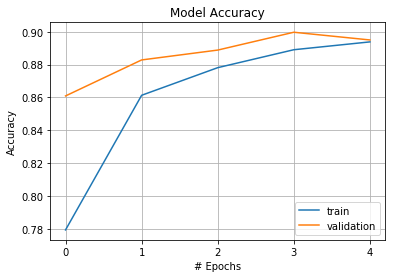

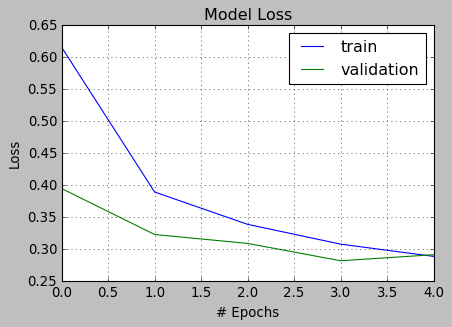

In [17]:
epoch = len(training_history.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),training_history.history['acc'])
plt.plot(range(epoch),training_history.history['val_acc'])
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),training_history.history['loss'])
plt.plot(range(epoch),training_history.history['val_loss'])
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'])
plt.style.use(['classic'])


Model accuracy should increase with each epoch and loss decrease. Do note though that you might observe that [overfitting](https://en.wikipedia.org/wiki/Overfitting) has occured if accuracy drops and the loss increases for the validation data, whereas it improves for the training data.

### Save the model

You can save the trained model for later re-use in a file using [`model.save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save). The saved file includes
- the model architecture, which allows for re-instantiation of the model
- the model weights
- the optimizer state, which allows for resuming of the training where you left off

In [18]:
# Use save function to export model
model.save('fashion_mnist.h5')
# model.save('fashion_mnist.h5', save_format='h5') # TensorFlow 2.x

<a id="cell5"></a>
### 5. Test and Evaluate Model Performance

Now that we've trained the model it is time to test how accurate its predictions are for the unseen data in `fashion-mnist_test.csv`.
We'll:
- Prepare the test data
- Run predictions on the test data
- Sample the prediction results
- Calculate and visualize model performance metrics


#### Prepare the Test Data

Prepare the test data like we've done earlier with the training data.

In [19]:
# Convert data points from pixels to weighted values
X_test = test_data[:, 1:].reshape(test_data.shape[0],28, 28, 1).astype( 'float32' )
test_input_data = X_test/ 255.0

# Save the actual label of the test data - we can call it 'correct answer'
label = test_data[:,0]
test_output_data = lb.transform(label)

#### Run Predictions on Test Data

Use [`model.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) to predict which clothing items are depicted in the test data set. The method returns an Numpy array of predictions.

In [20]:
# Predict the labels for the unseen test data
predictions = model.predict(test_input_data)

#### Review the Prediction Results

Each row in this array contains a numeric score (ranging from 0 and 1) for each of the 10 classes that we trained the model on, indicating the likelihood that the depicted clothing item belongs to the class. For the first image in the test data set the predictions look as follows:

In [21]:
predictions[0]

array([9.1445982e-01, 1.3644809e-08, 6.3881598e-05, 7.9397149e-05,
       5.3580652e-07, 4.6905466e-09, 8.5395157e-02, 2.2785895e-09,
       1.2495784e-06, 2.0886315e-09], dtype=float32)

The higher the score, the more confident the model is that the depicted clothing item belongs to the class. Calculate the maximum for each rows to determine what the predicted label is:

In [22]:
pred_label = [np.argmax(i) for i in predictions]

Let's take a peek at the predicted label and the correct label for the first clothing item in the test data set:

In [23]:
print('Predicted label for the first clothing item: {}'.format(pred_label[0]))
print('Correct label for the first clothing item:   {}'.format(label[0]))

Predicted label for the first clothing item: 0
Correct label for the first clothing item:   0


Ideally the prediction should be correct, but your results might vary. Let's tally up the numbers for the entire test data.

In [24]:
# identify correctly and incorrectly classified clothing items

correctly_classified = []
incorrectly_classified = []
index = 0
for actual, predict in zip(label, pred_label):
    if actual == predict:
        correctly_classified.append(index)
    else:
        incorrectly_classified.append(index)
    index += 1

ccc = len(correctly_classified)
icc = len(incorrectly_classified)
print('Correctly classified clothing items  : {:5d} ({:=5.2f} %)'.format(ccc, ccc * 100 / (ccc + icc)))    
print('Incorrectly classified clothing items: {:5d} ({:=5.2f} %)'.format(icc, icc * 100 / (ccc + icc)))    

Correctly classified clothing items  :  8992 (89.92 %)
Incorrectly classified clothing items:  1008 (10.08 %)


While this breakdown is useful, it doesn't provide any details as to how well the model can identify individual clothing items.
In machine learning, a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is commonly used to visualize the performance of a classification algorithm.

Calculate the confusion matrix using the correct labels and predicted labels as input, using scikit-learn's [`sklearn.metrics.confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method. We then use the [seaborn](https://seaborn.pydata.org/) visualization library to display thye matrix as a heatmap.


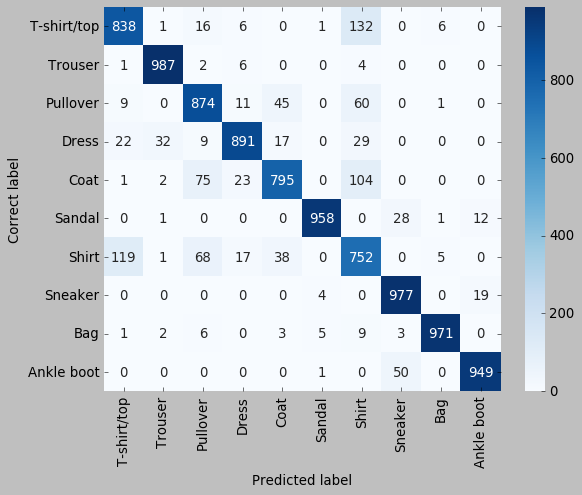

In [25]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(label, pred_label)

# display confusion matrix as heatmap
ax = sns.heatmap(conf_matrix, 
            cmap='Blues', 
            xticklabels=label_map, 
            yticklabels=label_map,
            annot=True,
            fmt='d')

plt.xlabel('Predicted label') 
plt.ylabel('Correct label') 

plt.show()

For the Fashion-MNIST data set the output is a 10 by 10 matrix, comprising of one row and column per class. The correct predictions are located in the diagonal. The number of incorrectly classified clothing items are displayed outside that diagonal. Inspecting the output, it appears that the trained model incorrectly idenitifies quite a few clothing items as t-shirts and shirts.

For illustrative purposes we'll inspect a few of the incorrectly classified clothing items. While this probably won't provide you with any useful insights, it might satisfy your curiosity.

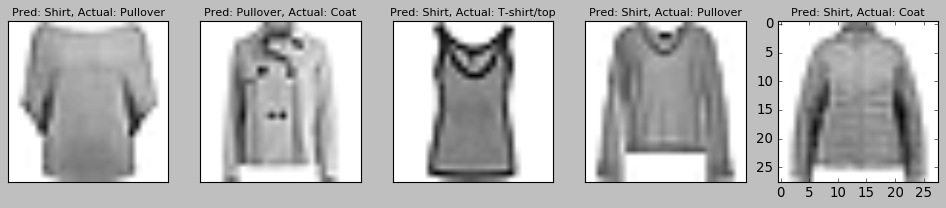

In [26]:
# plot up to max_preview clothing items that were correctly identified
max_preview = 5

plt.figure(figsize=(15,15))
for index, fail_index in enumerate(incorrectly_classified[0:max_preview]):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4, 5, index + 1)
    plt.imshow(np.reshape(X_test[fail_index], (28,28)), cmap=plt.cm.binary)
    plt.title('Pred: {}, Actual: {}'.format(label_map[pred_label[fail_index]], label_map[label[fail_index]]), fontsize = 10)

Next, we'll calculate precision, recall, and accuracy to formally quantify the model performance. 

#### Calculate the precision scores

We use scikit-learn's [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score) method to calculate the precision for each of the 10 classes, using the correct labels and predicted labels as input. The precision quantifies the ability of the classifier not to label as positive a sample that is negative. For example, if many clothing items are incorrectly classified as shirts the precision score for shirts should be lower. A value of 1 is best and 0 the worst.

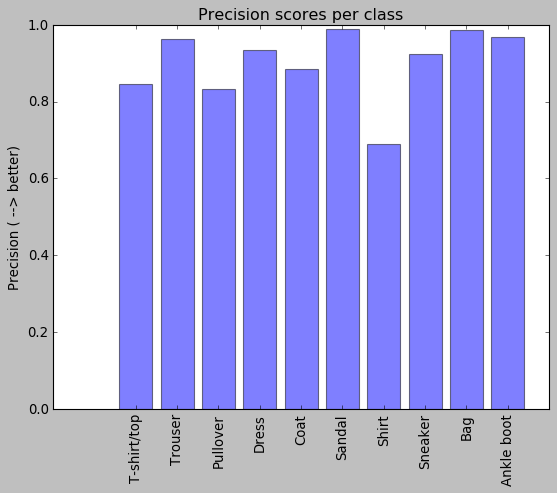

In [27]:
# Calculate precision scores
precision_scores = precision_score(label, pred_label, average=None)

y_pos = np.arange(len(precision_scores))

plt.bar(y_pos, precision_scores, align='center', alpha=0.5)
plt.xticks(y_pos, label_map, rotation=90)
plt.ylabel('Precision ( --> better)')
plt.title('Precision scores per class')

plt.show()

The precision score for shirts indicates that the model incorrectly identifies quite a few clothing items that are not shirts as shirts.

#### Calculate the recall

We use scikit-learn's [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) method to calculate the precision for each of the 10 classes, using the correct labels and predicted labels as input. The recall quantifies the ability of the classifier find all positive examples. For example, a high recall value for trousers indicates that the model does well identifying trousers. A value of 1 is best and 0 the worst.

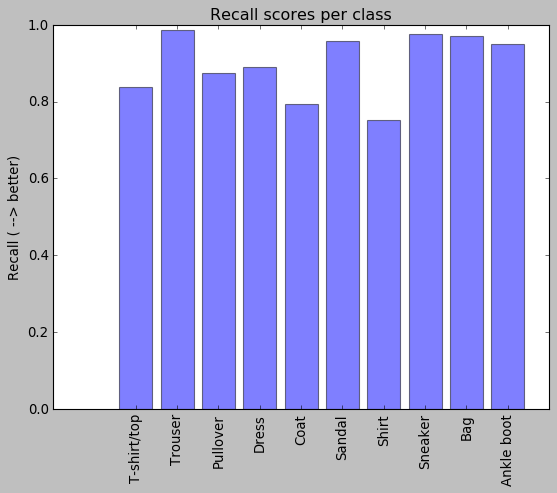

In [28]:
# Calculate recall score for each class
recall_scores = recall_score(label, pred_label, average=None)

# Visualize recall scores

y_pos = np.arange(len(recall_scores))

plt.bar(y_pos, recall_scores, align='center', alpha=0.5)
plt.xticks(y_pos, label_map, rotation=90)
plt.ylabel('Recall ( --> better)')
plt.title('Recall scores per class')

plt.show()

It appears that the trained model isn't very good yet at correctly identifying pullovers, coats, and shirts.

#### Calculate the overall accuracy

We use scikit-learn's [`sklearn.metrics.acuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) method to calculate the accuracy score, using the correct labels and predicted labels as input. 

In [29]:
# Calculate accuracy score
accuracy_score(label, pred_label)

0.8992

#### Conclusions

Our trained model evaluation has identified a few weaknesses that have an impact on the overall performance of this model. Given the insights you could try the following to improve the model's prediction performance for poorly classified classes, such as shirts and t-shirts:
 - Tune the model hyperparameters in order to improve performance on those classes, without degrading the performance for other classes.
 - Collect more images for those classes to give the model more data to learn from.
 - Apply data augmentation approaches. For image data, this can be creating more data artificially by doing “flips”, “rotations”, playing with color, brightness, etc in order to create more and “more difficult to classify” training examples in order to allow the model to learn more with the same amount of actual data.

#### Next steps

- Close this notebook.


<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).
<br><br>

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.
<br><br>
<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>